In [4]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [23]:
import pickle
import gensim
import pyLDAvis
import pyLDAvis.gensim_models
import pandas as pd
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
import warnings
from pprint import pprint
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Preethi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
#import the enron preprocessed dataset 

C:\Users\Aadhithya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
df = pd.read_csv('C:/Users/Preethi/Downloads/preprocessed_enron_final_v2.1.csv')


In [8]:
df

,x_from,x_to,user,lemmatized,stemmed_tokens,tag
0,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,allen-p,Here forecast,here forecast,0
1,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,allen-p,Traveling business take fun trip Especially pr...,travel busi take fun trip especi prepar presen...,0
2,Phillip K Allen,Randall L Gay,allen-p,Randy Can send schedule salary level everyone ...,randi can send schedul salari level everyon sc...,0
3,Phillip K Allen,Keith Holst,allen-p,Forwarded Phillip K PM Richard Burchfield AM T...,forward phillip k pm richard burchfield am to ...,0
4,Phillip K Allen,David W Delainey,allen-p,Dave Here west desk category The origination s...,dave here west desk categori the origin side s...,0
...,...,...,...,...,...,...
25710,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Richey, Cooper </O=ENRON/OU=NA/CN=RECIPIENTS/C...",zufferli-j,A buddy mine selling stuff start need contact ...,a buddi mine sell stuff start need contact mes...,0
25711,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Dorland, Chris </O=ENRON/OU=NA/CN=RECIPIENTS/C...",zufferli-j,Check www.segalmotorcar.com,check www.segalmotorcar.com,0
25712,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Richey, Cooper </O=ENRON/OU=NA/CN=RECIPIENTS/C...",zufferli-j,Message From `` Ritter Fred Fred.Ritter eal.ab...,messag from `` ritter fred fred.ritt eal.ab.ca...,0
25713,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Kitchen, Louise </O=ENRON/OU=NA/CN=RECIPIENTS/...",zufferli-j,Here info staff John Z Message From Milnthorp ...,here info staff john z messag from milnthorp r...,0


In [9]:
df.drop_duplicates(inplace=True)

In [10]:
#visualization of contents

In [11]:
df['lem_len'] = df['lemmatized'].apply(lambda x: len(str(x).split()))

Text(0.5, 0, '')

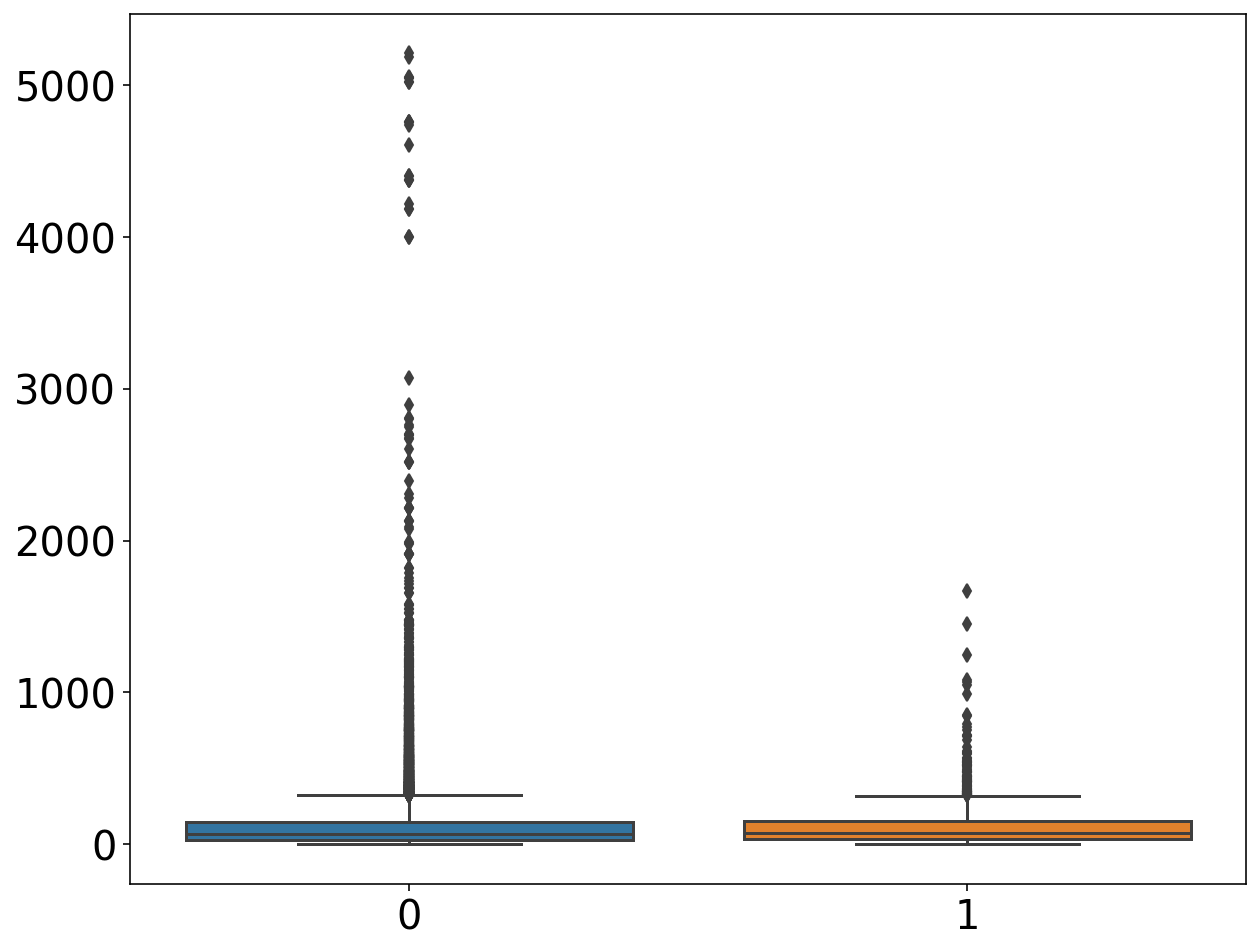

In [12]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.boxplot(x = 'tag', y = 'lem_len', data = df)
plt.ylabel('')
plt.xlabel('')

C:\Users\Preethi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, '')

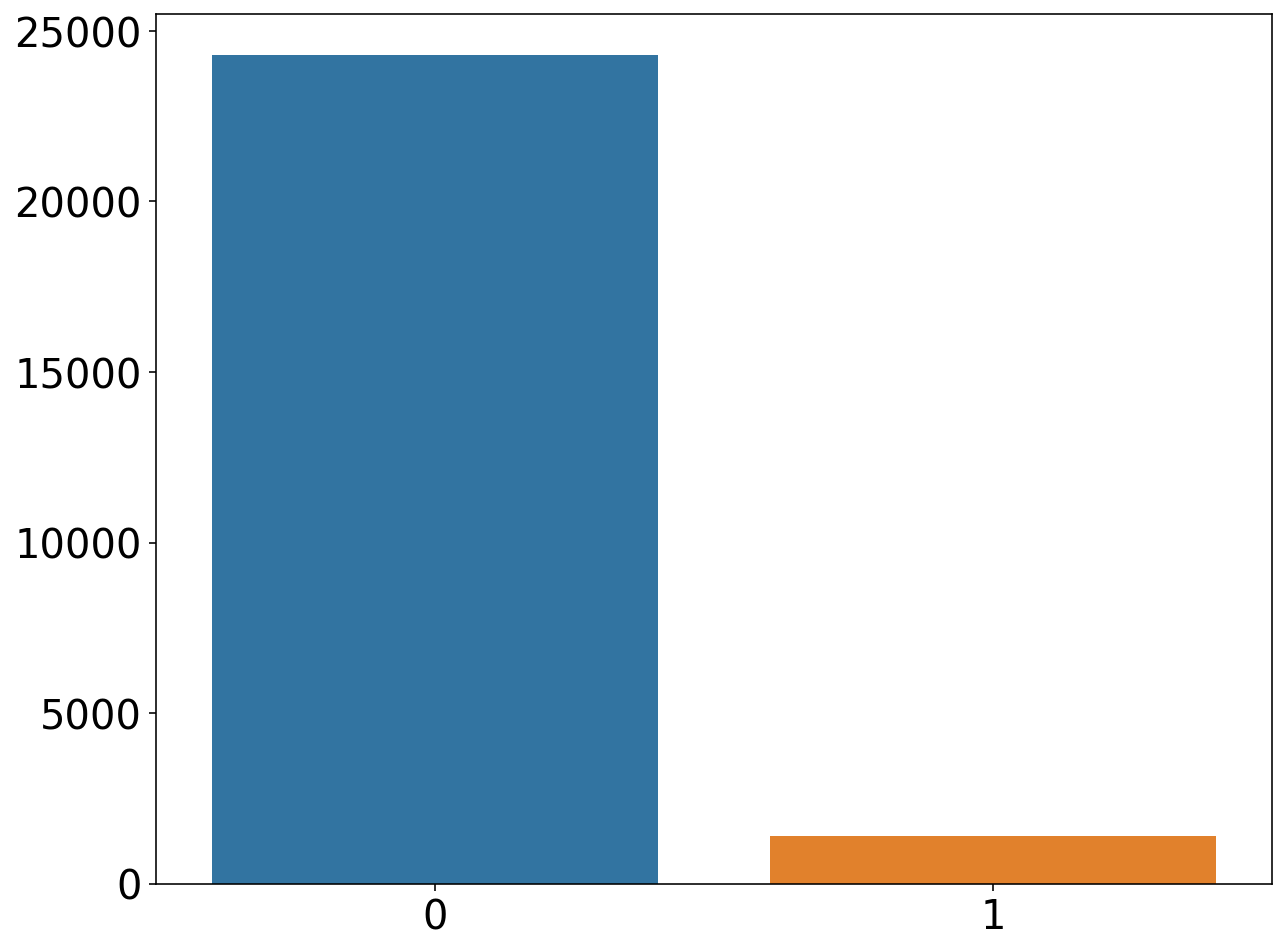

In [13]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.countplot('tag', data = df)
plt.ylabel('')
plt.xlabel('')

In [14]:
#since the max size of criminal size is around 2000, we take it as maximimum limit for further application

In [15]:
print(len(df))
mask = (df['lemmatized'].str.len() > 0) & (df['lemmatized'].str.len() < 2100)
df = df.loc[mask]
print(len(df))

25675
23380


In [16]:
#preparing a dataset sample with almost equal amount of criminal and non criminal files for better clasification

In [17]:
T1 = df[df['tag'] == 0].copy()
T2=df[df['tag'] == 1].copy()
T3 = T1.iloc[:1500,:].copy()
df = pd.concat([T2.reset_index(drop=True),T3.reset_index(drop=True)], axis=0)
df = df.sample(frac = 1)

In [18]:
df.head()

,x_from,x_to,user,lemmatized,stemmed_tokens,tag,lem_len
650,"Bowen Jr., Raymond </O=ENRON/OU=NA/CN=RECIPIEN...","Denne, Karen </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...",kean-s,... let circulate usual suspect well fax Ken A...,... let circul usual suspect well fax ken also...,1,23
1170,"Hannon, Kevin","Lay, Kenneth </o=ENRON/ou=NA/cn=Recipients/cn=...",skilling-j,To Enron Corporate Policy Committee Please rev...,to enron corpor polici committe pleas review a...,1,23
538,John Arnold,John J Lavorato <John J Lavorato/ENRON@enronXg...,arnold-j,none From =09John J enronXgate AM To =09Philli...,none from =09john j enronxg am to =09phillip k...,0,145
63,Phillip K Allen,"Mike Grigsby, Keith Holst, Frank Ermis, Jane M...",allen-p,Forwarded Phillip K AM D Steffes ENRON AM To P...,forward phillip k am d steff enron am to phill...,0,176
993,"Sturm, Fletcher J. </O=ENRON/OU=NA/CN=RECIPIEN...","Baughman Jr., Don </O=ENRON/OU=NA/CN=RECIPIENT...",baughman-d,thank great 1st half year fletch Message From ...,thank great 1st half year fletch messag from b...,0,53


In [19]:
#preparing the data to feed it for the lda model

In [20]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['-','``', "'", '/', ':', 'I', 'me', 'my', 'could', 'can','the','to','and','of','in','on','for','is','that','com','you','this','from','be','with','have','will','are','subject','pm','cc','would','enron','sent','message','email','','ect','please'])

In [21]:
!pip install spacey

In [24]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

NameError: name 'spacy' is not defined

In [25]:
def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [26]:
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

In [27]:
def get_corpus(df):
    """
    Get Bigram Model, Corpus, id2word mapping
    """
    
    df['lemmatized'] = strip_newline(df.lemmatized)
    words = list(sent_to_words(df.lemmatized))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
#     lemma = lemmatization(bigram)
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [28]:
train_corpus4, train_id2word4, bigram_train4 = get_corpus(df)

In [29]:
#impoting ang the model

In [30]:
import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus4,
                           num_topics=20,
                           id2word=train_id2word4,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
    lda_train4.save('lda_train4.model')

In [31]:
#model coherence calculated here

In [32]:
coherence_model_lda = CoherenceModel(model=lda_train4, texts=bigram_train4, dictionary=train_id2word4, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.38556279710307656

In [33]:
#sample of lda topics from lda

In [34]:
lda_train4.print_topics(20,num_words=15)[:10]

[(0,
  '0.034*"go" + 0.026*"think" + 0.016*"eric" + 0.015*"get" + 0.014*"still" + 0.013*"curve" + 0.013*"good" + 0.013*"see" + 0.012*"john" + 0.012*"back" + 0.012*"tonight" + 0.011*"try" + 0.010*"give" + 0.010*"let_know" + 0.010*"today"'),
 (1,
  '0.059*"ees" + 0.021*"california" + 0.017*"phillip" + 0.014*"gas" + 0.013*"file" + 0.012*"letter" + 0.012*"jeff" + 0.012*"ferc" + 0.011*"socal" + 0.011*"dan" + 0.010*"forwarded_phillip" + 0.010*"pg" + 0.010*"richard" + 0.010*"forwarded" + 0.010*"rate"'),
 (2,
  '0.017*"review" + 0.017*"copy" + 0.017*"may" + 0.016*"today" + 0.015*"file" + 0.015*"corp" + 0.014*"draft" + 0.013*"thank" + 0.012*"delete" + 0.011*"intend" + 0.011*"intend_recipient" + 0.011*"tuesday_november" + 0.010*"natural_gas" + 0.010*"doc" + 0.010*"contract"'),
 (3,
  '0.023*"pay" + 0.020*"edison" + 0.019*"chart" + 0.018*"offer" + 0.016*"web" + 0.014*"soblander_carrfut" + 0.013*"via" + 0.011*"option" + 0.010*"click" + 0.010*"carr_futures" + 0.010*"http" + 0.009*"matrix" + 0.009*"

In [35]:
#vectorizing the topics to feed it to lohistic regression

In [36]:
train_vecs = []
for i in range(len(df)):
    top_topics = lda_train4.get_document_topics(train_corpus4[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    
    topic_vec.extend([len(df.iloc[i].lemmatized)]) # length review
    train_vecs.append(topic_vec)

In [37]:
train_vecs[2]

[0.00069449784,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 0.9868046,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 0.00069449784,
 823]

In [38]:
X = np.array(train_vecs)

In [39]:
y = np.array(df.tag)

In [40]:
#the data is prepared and fed to the model here

In [41]:
kf = KFold(5, shuffle=True, random_state=42)
cv_lr_f1, cv_lrsgd_f1, cv_svcsgd_f1,  = [], [], []

for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)

    # Logisitic Regression
    lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

    y_pred = lr.predict(X_val_scale)
    cv_lr_f1.append(f1_score(y_val, y_pred, average='binary'))
    
    # Logistic Regression Mini-Batch SGD
    sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd.predict(X_val_scale)
    cv_lrsgd_f1.append(f1_score(y_val, y_pred, average='binary'))
    
 





In [42]:
print(f'Logistic Regression Val f1: {np.mean(cv_lr_f1):.3f} +- {np.std(cv_lr_f1):.3f}')
print(f'Logisitic Regression SGD Val f1: {np.mean(cv_lrsgd_f1):.3f} +- {np.std(cv_lrsgd_f1):.3f}')

Logistic Regression Val f1: 0.711 +- 0.006
Logisitic Regression SGD Val f1: 0.670 +- 0.021


In [43]:
for i in range(10):
    print('Actual Class label : ',y_val[i],end=' ')
    print('Predicted Class label : ',y_pred[i])

Actual Class label :  1 Predicted Class label :  0
Actual Class label :  0 Predicted Class label :  1
Actual Class label :  1 Predicted Class label :  1
Actual Class label :  0 Predicted Class label :  0
Actual Class label :  1 Predicted Class label :  1
Actual Class label :  0 Predicted Class label :  0
Actual Class label :  0 Predicted Class label :  1
Actual Class label :  1 Predicted Class label :  1
Actual Class label :  0 Predicted Class label :  1
Actual Class label :  1 Predicted Class label :  1


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [45]:
cm = metrics.confusion_matrix(y_val, y_pred)
print(cm)


[[212  91]
 [ 72 183]]


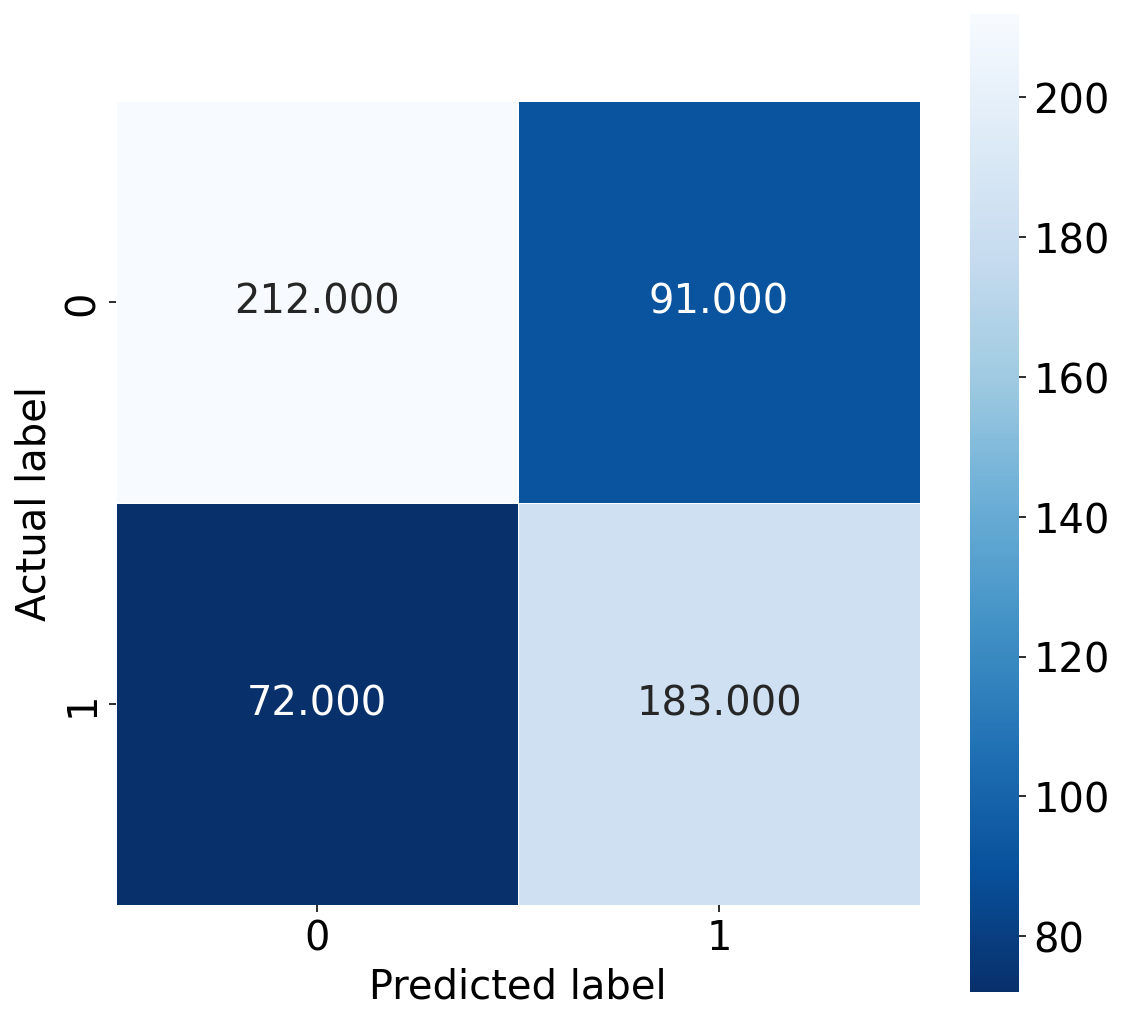

In [46]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');



In [47]:
sgd.score(X_val,y_val)

0.45698924731182794

In [48]:
lr.score(X_val,y_val)

0.45698924731182794